# Freedom Cards Data Exploration

Exploring the raw data collected for both Freedom Unlimited and Freedom Flex cards.

UPDATE: Results:
36% approval rate (17 approved, 29 denied)
Limited data extraction (6.5% income, 54% credit scores)
POC model: AUC 0.42 (worse than random), 50% accuracy
Key Insights:
Student status and first-time cardholder are positive predictors
Higher income/credit scores correlate with denials (counterintuitive)
47 samples too small for reliable modeling
Next Steps:
Need 500+ samples for meaningful ML
Expand data collection to other sources
Improve extraction accuracy
Consider different card types for larger dataset

### Cell 1: Load and explore the data


In [20]:
%pip install --quiet pandas matplotlib seaborn scikit-learn





[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Cell 2: Basic statistics and data quality


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('../data/processed/hybrid_llm_dataset_20250718_195610.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

Dataset shape: (47, 28)
Columns: ['Title', 'URL', 'Body', 'Source', 'Card_Name', 'Scraped_At', 'approval_status', 'title_quality_score', 'Extracted Income', 'Extracted Credit Score', 'Extracted Approval Amount', 'income_clean', 'credit_score_clean', 'approval_amount_clean', 'target', 'is_student', 'is_first_card', 'has_chase_account', 'mentions_income', 'mentions_credit_score', 'text_length', 'llm_approval_status', 'llm_confidence', 'llm_income', 'llm_credit_score', 'llm_approval_amount', 'llm_reasoning', 'used_llm']

First few rows:
                                               Title  \
0  Can I be approved for Chase Freedom Unlimited ...   
1           Would i get approved? Or is it too soon?   
2  Denied - CFU Purchase Protection - outside pro...   
3                 Denied for Chase Freedom Unlimited   
4  Denied Chase Freedom Unlimited Wrong Credit Score   

                                                 URL  \
0  https://www.reddit.com/r/CreditCards/comments/...   
1  https://

### Cell 3: Comprehensive visualizations


In [28]:
# Check data quality
print("DATA QUALITY")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"\nApproval status distribution:\n{df['approval_status'].value_counts()}")
print(f"\nCard distribution:\n{df['Card_Name'].value_counts()}")

# Check extracted fields
print(f"\nEXTRACTED FIELDS")
print(f"Income extracted: {df['income_clean'].notna().sum()}/{len(df)}")
print(f"Credit score extracted: {df['credit_score_clean'].notna().sum()}/{len(df)}")
print(f"Approval amount extracted: {df['approval_amount_clean'].notna().sum()}/{len(df)}")

# Show some examples of extracted data
print(f"\nSAMPLE EXTRACTED DATA")
sample_data = df[['Title', 'approval_status', 'income_clean', 'credit_score_clean', 'approval_amount_clean']].head(10)
print(sample_data)

DATA QUALITY
Missing values:
Title                         0
URL                           0
Body                          0
Source                        0
Card_Name                     0
Scraped_At                    0
approval_status               0
title_quality_score           0
Extracted Income             43
Extracted Credit Score       21
Extracted Approval Amount    40
income_clean                  0
credit_score_clean            0
approval_amount_clean         0
target                        1
is_student                    0
is_first_card                 0
has_chase_account             0
mentions_income               0
mentions_credit_score         0
text_length                   0
llm_approval_status          40
llm_confidence                0
llm_income                   46
llm_credit_score             43
llm_approval_amount          46
llm_reasoning                41
used_llm                      0
dtype: int64

Approval status distribution:
approval_status
denied      29


### Cell 4: Feature analysis and patterns


/var/folders/xx/dcdf2ph51j95qzcp464_68v00000gn/T/ipykernel_498/3210864810.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quality_approval = df.groupby('quality_bins')['target'].mean()


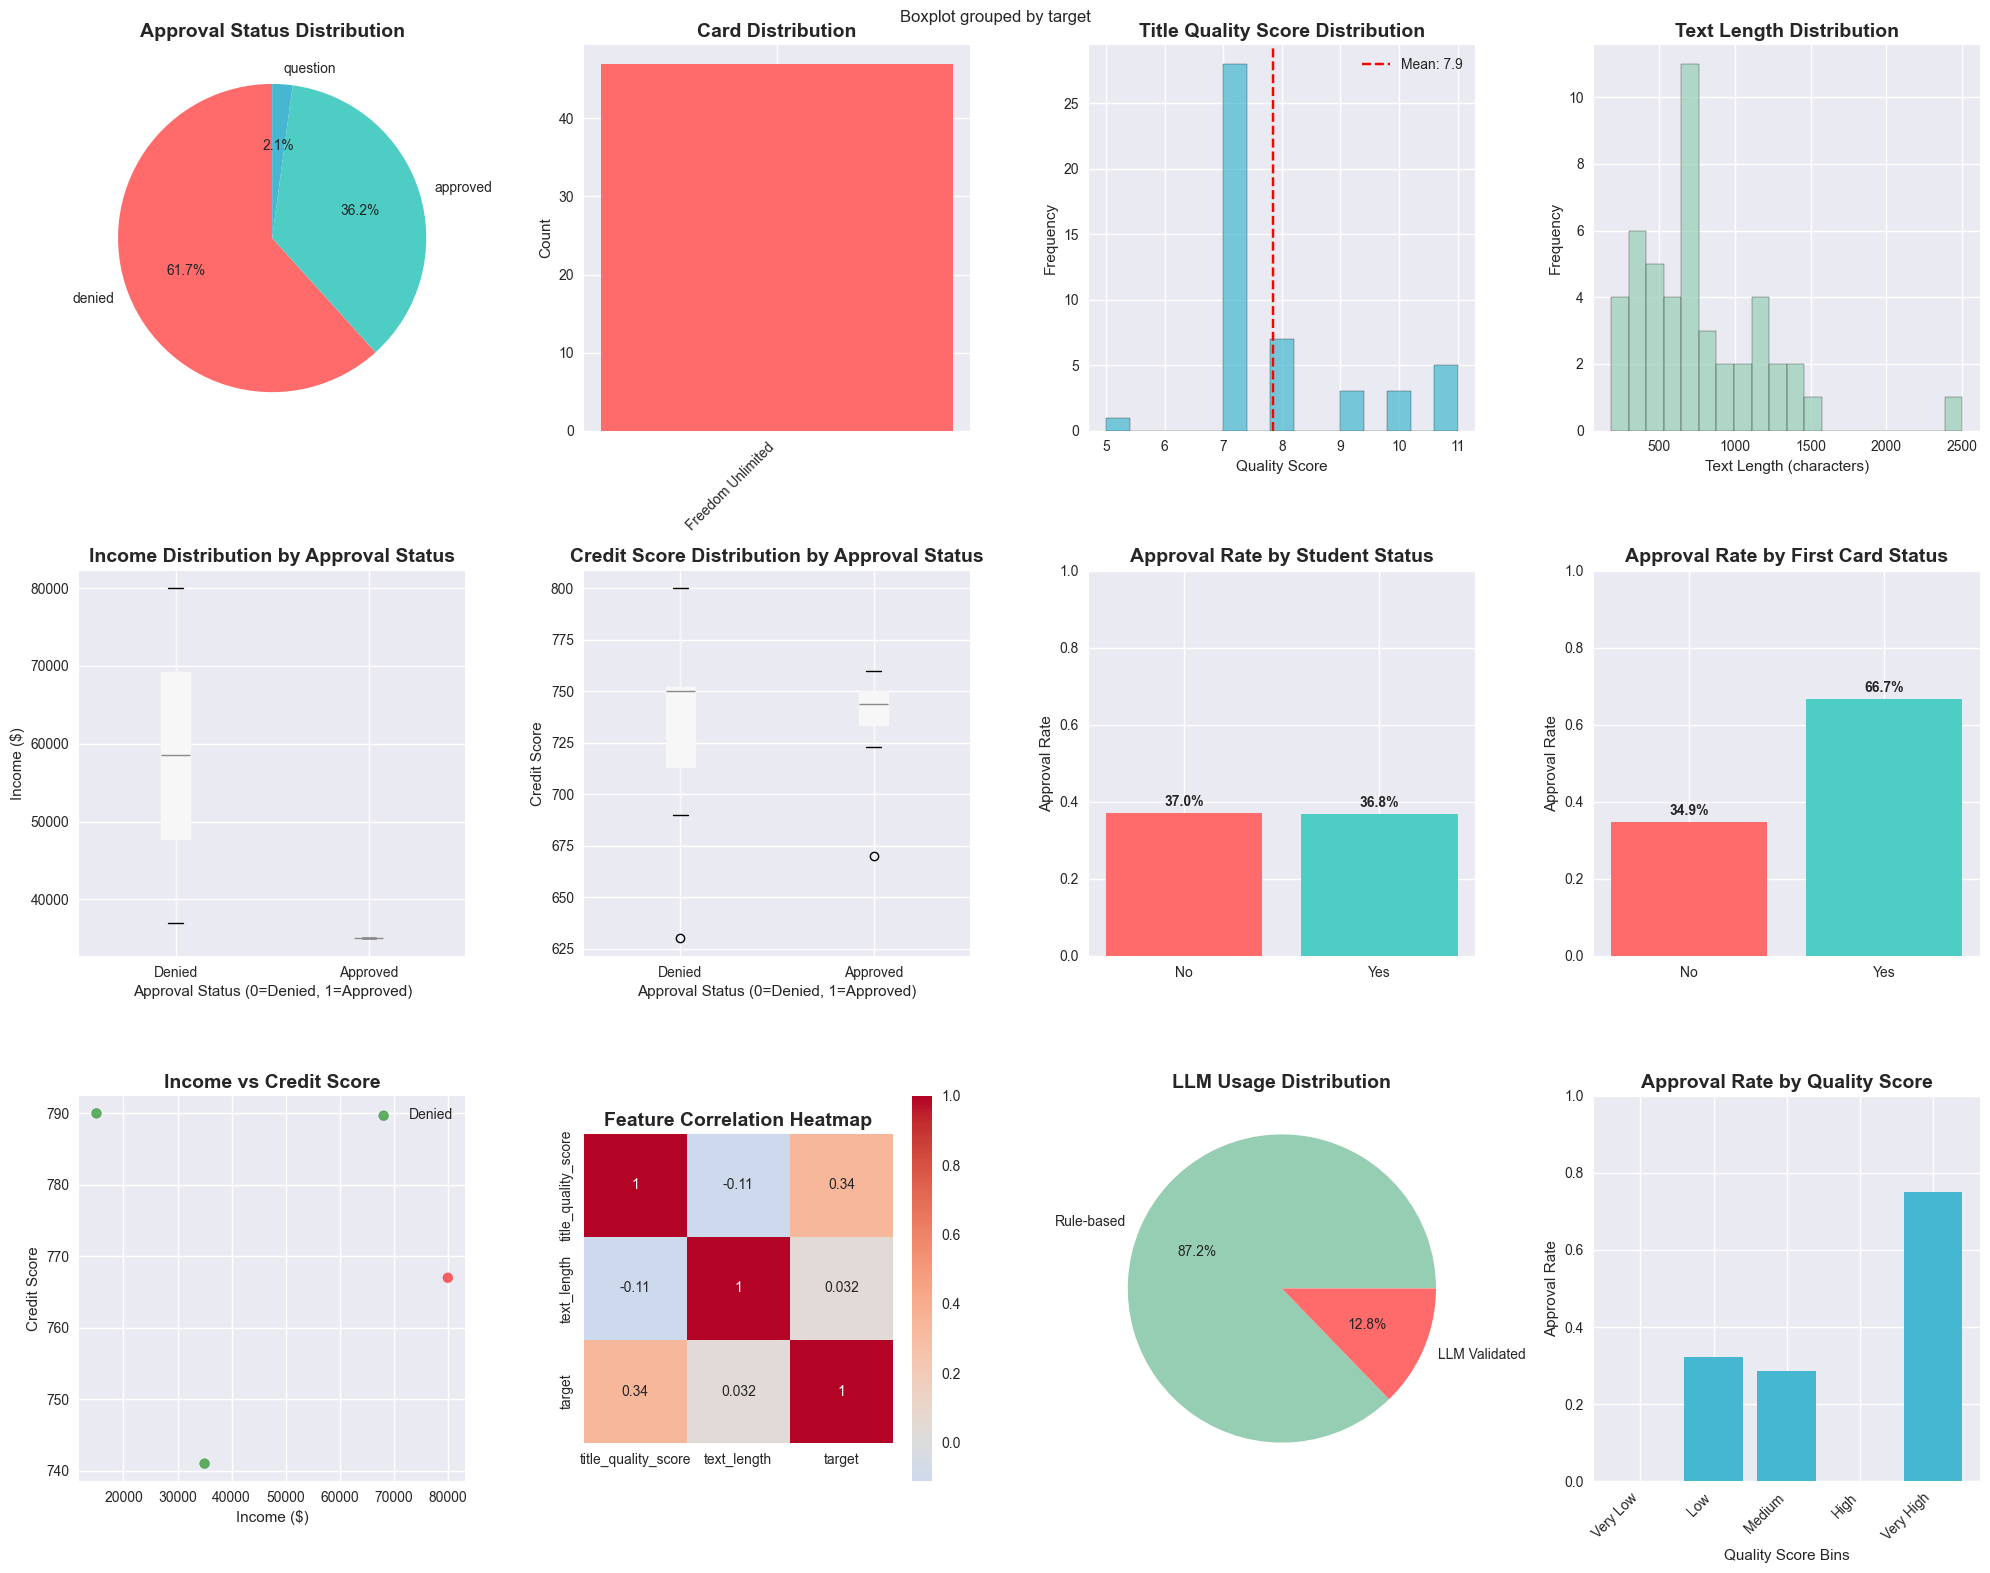

In [31]:
# Create a comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 16))

# 1. Approval status distribution (pie chart)
ax1 = plt.subplot(3, 4, 1)
approval_counts = df['approval_status'].value_counts()
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
ax1.pie(approval_counts.values, labels=approval_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Approval Status Distribution', fontsize=14, fontweight='bold')

# 2. Card distribution (bar chart)
ax2 = plt.subplot(3, 4, 2)
card_counts = df['Card_Name'].value_counts()
bars = ax2.bar(card_counts.index, card_counts.values, color=['#ff6b6b', '#4ecdc4'])
ax2.set_title('Card Distribution', fontsize=14, fontweight='bold')
ax2.set_ylabel('Count')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. Title quality score distribution (histogram)
ax3 = plt.subplot(3, 4, 3)
ax3.hist(df['title_quality_score'], bins=15, color='#45b7d1', alpha=0.7, edgecolor='black')
ax3.set_title('Title Quality Score Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Quality Score')
ax3.set_ylabel('Frequency')
ax3.axvline(df['title_quality_score'].mean(), color='red', linestyle='--', label=f'Mean: {df["title_quality_score"].mean():.1f}')
ax3.legend()

# 4. Text length distribution
ax4 = plt.subplot(3, 4, 4)
ax4.hist(df['text_length'], bins=20, color='#96ceb4', alpha=0.7, edgecolor='black')
ax4.set_title('Text Length Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Text Length (characters)')
ax4.set_ylabel('Frequency')

# 5. Income vs Approval (box plot)
ax5 = plt.subplot(3, 4, 5)
income_data = df[df['income_clean'] != 'Not extracted'].copy()
if len(income_data) > 0:
    income_data['income_clean'] = pd.to_numeric(income_data['income_clean'])
    income_data.boxplot(column='income_clean', by='target', ax=ax5, patch_artist=True)
    ax5.set_title('Income Distribution by Approval Status', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Approval Status (0=Denied, 1=Approved)')
    ax5.set_ylabel('Income ($)')
    ax5.set_xticklabels(['Denied', 'Approved'])

# 6. Credit score vs Approval (box plot)
ax6 = plt.subplot(3, 4, 6)
credit_data = df[df['credit_score_clean'] != 'Not extracted'].copy()
if len(credit_data) > 0:
    credit_data['credit_score_clean'] = pd.to_numeric(credit_data['credit_score_clean'])
    credit_data.boxplot(column='credit_score_clean', by='target', ax=ax6, patch_artist=True)
    ax6.set_title('Credit Score Distribution by Approval Status', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Approval Status (0=Denied, 1=Approved)')
    ax6.set_ylabel('Credit Score')
    ax6.set_xticklabels(['Denied', 'Approved'])

# 7. Student status vs Approval (bar chart)
ax7 = plt.subplot(3, 4, 7)
student_approval = df.groupby('is_student')['target'].mean()
bars = ax7.bar(student_approval.index, student_approval.values, color=['#ff6b6b', '#4ecdc4'])
ax7.set_title('Approval Rate by Student Status', fontsize=14, fontweight='bold')
ax7.set_ylabel('Approval Rate')
ax7.set_ylim(0, 1)
for bar, value in zip(bars, student_approval.values):
    ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.1%}', 
             ha='center', va='bottom', fontweight='bold')

# 8. First card status vs Approval (bar chart)
ax8 = plt.subplot(3, 4, 8)
first_card_approval = df.groupby('is_first_card')['target'].mean()
bars = ax8.bar(first_card_approval.index, first_card_approval.values, color=['#ff6b6b', '#4ecdc4'])
ax8.set_title('Approval Rate by First Card Status', fontsize=14, fontweight='bold')
ax8.set_ylabel('Approval Rate')
ax8.set_ylim(0, 1)
for bar, value in zip(bars, first_card_approval.values):
    ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.1%}', 
             ha='center', va='bottom', fontweight='bold')

# 9. Income vs Credit Score scatter plot (FIXED)
ax9 = plt.subplot(3, 4, 9)
if len(income_data) > 0 and len(credit_data) > 0:
    # Merge on index instead of Title to avoid column name issues
    combined = pd.merge(income_data, credit_data, left_index=True, right_index=True, how='inner')
    colors = ['red' if x == 0 else 'green' for x in combined['target_x']]
    ax9.scatter(combined['income_clean_x'], combined['credit_score_clean_y'], c=colors, alpha=0.6, s=50)
    ax9.set_title('Income vs Credit Score', fontsize=14, fontweight='bold')
    ax9.set_xlabel('Income ($)')
    ax9.set_ylabel('Credit Score')
    ax9.legend(['Denied', 'Approved'], loc='upper right')

# 10. Feature correlation heatmap
ax10 = plt.subplot(3, 4, 10)
numeric_cols = ['title_quality_score', 'text_length', 'target']
correlation_data = df[numeric_cols].corr()
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, ax=ax10, square=True)
ax10.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')

# 11. LLM usage distribution
ax11 = plt.subplot(3, 4, 11)
if 'used_llm' in df.columns:
    llm_counts = df['used_llm'].value_counts()
    colors = ['#96ceb4', '#ff6b6b']
    ax11.pie(llm_counts.values, labels=['Rule-based', 'LLM Validated'], autopct='%1.1f%%', colors=colors)
    ax11.set_title('LLM Usage Distribution', fontsize=14, fontweight='bold')

# 12. Approval rate by quality score bins
ax12 = plt.subplot(3, 4, 12)
df['quality_bins'] = pd.cut(df['title_quality_score'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
quality_approval = df.groupby('quality_bins')['target'].mean()
bars = ax12.bar(range(len(quality_approval)), quality_approval.values, color='#45b7d1')
ax12.set_title('Approval Rate by Quality Score', fontsize=14, fontweight='bold')
ax12.set_ylabel('Approval Rate')
ax12.set_xlabel('Quality Score Bins')
ax12.set_xticks(range(len(quality_approval)))
ax12.set_xticklabels(quality_approval.index, rotation=45, ha='right')
ax12.set_ylim(0, 1)

plt.tight_layout()
plt.show()

### Cell 5: Advanced visualizations

In [32]:
# Analyze patterns in approvals vs denials
print("APPROVAL PATTERNS")

# Income analysis
income_data = df[df['income_clean'] != 'Not extracted'].copy()
income_data['income_clean'] = pd.to_numeric(income_data['income_clean'])

if len(income_data) > 0:
    print(f"Income analysis ({len(income_data)} samples):")
    print(f"Approved - Avg income: ${income_data[income_data['target']==1]['income_clean'].mean():,.0f}")
    print(f"Denied - Avg income: ${income_data[income_data['target']==0]['income_clean'].mean():,.0f}")

# Credit score analysis
credit_data = df[df['credit_score_clean'] != 'Not extracted'].copy()
credit_data['credit_score_clean'] = pd.to_numeric(credit_data['credit_score_clean'])

if len(credit_data) > 0:
    print(f"\nCredit score analysis ({len(credit_data)} samples):")
    print(f"Approved - Avg credit score: {credit_data[credit_data['target']==1]['credit_score_clean'].mean():.0f}")
    print(f"Denied - Avg credit score: {credit_data[credit_data['target']==0]['credit_score_clean'].mean():.0f}")

# Student status
print(f"\nStudent status:")
student_approval_rate = df[df['is_student']=='Yes']['target'].mean()
print(f"Students approval rate: {student_approval_rate:.1%}")

# First card status
print(f"\nFirst card status:")
first_card_approval_rate = df[df['is_first_card']=='Yes']['target'].mean()
print(f"First card approval rate: {first_card_approval_rate:.1%}")

APPROVAL PATTERNS
Income analysis (4 samples):
Approved - Avg income: $35,000
Denied - Avg income: $58,500

Credit score analysis (26 samples):
Approved - Avg credit score: 735
Denied - Avg credit score: 734

Student status:
Students approval rate: 36.8%

First card status:
First card approval rate: 66.7%


/var/folders/xx/dcdf2ph51j95qzcp464_68v00000gn/T/ipykernel_498/501098398.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(['Denied', 'Approved'])
/var/folders/xx/dcdf2ph51j95qzcp464_68v00000gn/T/ipykernel_498/501098398.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(['Denied', 'Approved'])


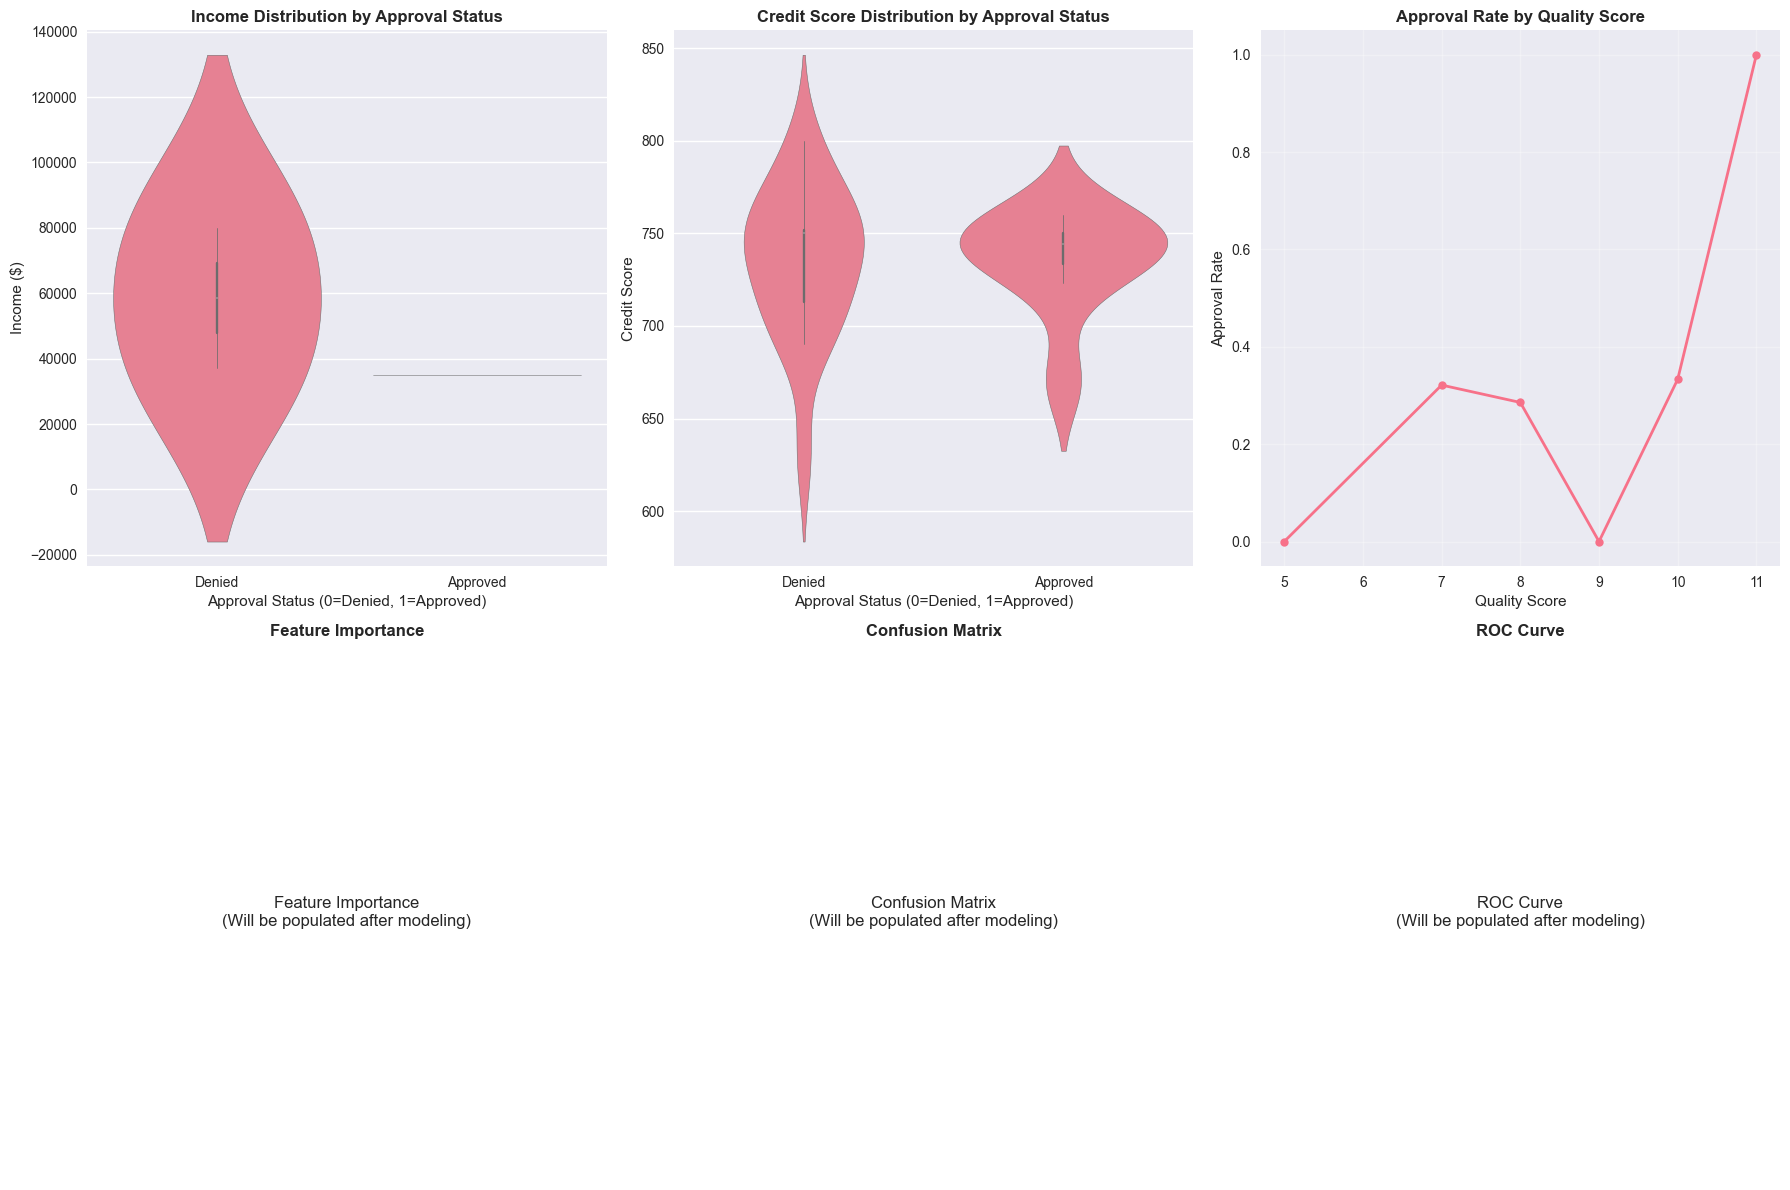

In [33]:
# Create additional advanced visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Income distribution by approval status (violin plot)
if len(income_data) > 0:
    sns.violinplot(data=income_data, x='target', y='income_clean', ax=axes[0,0])
    axes[0,0].set_title('Income Distribution by Approval Status', fontweight='bold')
    axes[0,0].set_xlabel('Approval Status (0=Denied, 1=Approved)')
    axes[0,0].set_ylabel('Income ($)')
    axes[0,0].set_xticklabels(['Denied', 'Approved'])

# 2. Credit score distribution by approval status (violin plot)
if len(credit_data) > 0:
    sns.violinplot(data=credit_data, x='target', y='credit_score_clean', ax=axes[0,1])
    axes[0,1].set_title('Credit Score Distribution by Approval Status', fontweight='bold')
    axes[0,1].set_xlabel('Approval Status (0=Denied, 1=Approved)')
    axes[0,1].set_ylabel('Credit Score')
    axes[0,1].set_xticklabels(['Denied', 'Approved'])

# 3. Quality score vs approval rate (line plot)
quality_approval = df.groupby('title_quality_score')['target'].mean()
axes[0,2].plot(quality_approval.index, quality_approval.values, marker='o', linewidth=2, markersize=6)
axes[0,2].set_title('Approval Rate by Quality Score', fontweight='bold')
axes[0,2].set_xlabel('Quality Score')
axes[0,2].set_ylabel('Approval Rate')
axes[0,2].grid(True, alpha=0.3)

# 4. Feature importance visualization (if we have model results)
axes[1,0].text(0.5, 0.5, 'Feature Importance\n(Will be populated after modeling)', 
               ha='center', va='center', transform=axes[1,0].transAxes, fontsize=12)
axes[1,0].set_title('Feature Importance', fontweight='bold')
axes[1,0].axis('off')

# 5. Confusion matrix placeholder
axes[1,1].text(0.5, 0.5, 'Confusion Matrix\n(Will be populated after modeling)', 
               ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
axes[1,1].set_title('Confusion Matrix', fontweight='bold')
axes[1,1].axis('off')

# 6. ROC curve placeholder
axes[1,2].text(0.5, 0.5, 'ROC Curve\n(Will be populated after modeling)', 
               ha='center', va='center', transform=axes[1,2].transAxes, fontsize=12)
axes[1,2].set_title('ROC Curve', fontweight='bold')
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

### Cell 6: Simple rule-based analysis


In [34]:
# Create simple rules based on patterns
print("SIMPLE RULES ANALYSIS")

# Rule 1: High credit score threshold
if len(credit_data) > 0:
    high_credit = credit_data[credit_data['credit_score_clean'] >= 750]
    if len(high_credit) > 0:
        high_credit_approval_rate = high_credit['target'].mean()
        print(f"Credit score >= 750: {len(high_credit)} people, {high_credit_approval_rate:.1%} approval rate")

# Rule 2: High income threshold
if len(income_data) > 0:
    high_income = income_data[income_data['income_clean'] >= 50000]
    if len(high_income) > 0:
        high_income_approval_rate = high_income['target'].mean()
        print(f"Income >= $50k: {len(high_income)} people, {high_income_approval_rate:.1%} approval rate")

# Rule 3: Combined high credit + income
if len(credit_data) > 0 and len(income_data) > 0:
    # Use a simpler approach to combine data
    high_both = df[
        (df['credit_score_clean'] != 'Not extracted') & 
        (df['income_clean'] != 'Not extracted') &
        (pd.to_numeric(df['credit_score_clean'], errors='coerce') >= 750) &
        (pd.to_numeric(df['income_clean'], errors='coerce') >= 50000)
    ]
    if len(high_both) > 0:
        high_both_approval_rate = high_both['target'].mean()
        print(f"Credit >= 750 AND Income >= $50k: {len(high_both)} people, {high_both_approval_rate:.1%} approval rate")

# Rule 4: Students
students = df[df['is_student'] == 'Yes']
if len(students) > 0:
    student_approval_rate = students['target'].mean()
    print(f"Students: {len(students)} people, {student_approval_rate:.1%} approval rate")

SIMPLE RULES ANALYSIS
Credit score >= 750: 13 people, 25.0% approval rate
Income >= $50k: 1 people, 0.0% approval rate
Credit >= 750 AND Income >= $50k: 1 people, 0.0% approval rate
Students: 20 people, 36.8% approval rate


### Cell 7: Simple logistic regression (POC)


SIMPLE LOGISTIC REGRESSION (POC)
Available features: ['income_numeric', 'credit_score_numeric', 'is_student_binary', 'is_first_card_binary', 'text_length']
After removing NaN targets: 46 samples
X shape: (46, 5)
y shape: (46,)
Sample sizes:
  income_numeric: 3/46 non-zero values
  credit_score_numeric: 25/46 non-zero values
  is_student_binary: 19/46 non-zero values
  is_first_card_binary: 3/46 non-zero values
  text_length: 46/46 non-zero values

Model Performance:
Training samples: 36
Test samples: 10

Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.83      0.67         6
         1.0       0.00      0.00      0.00         4

    accuracy                           0.50        10
   macro avg       0.28      0.42      0.33        10
weighted avg       0.33      0.50      0.40        10


Feature Importance:
income_numeric: -0.6140
credit_score_numeric: -0.4319
is_student_binary: 0.2181
is_first_card_binary: 0.3637
text_lengt

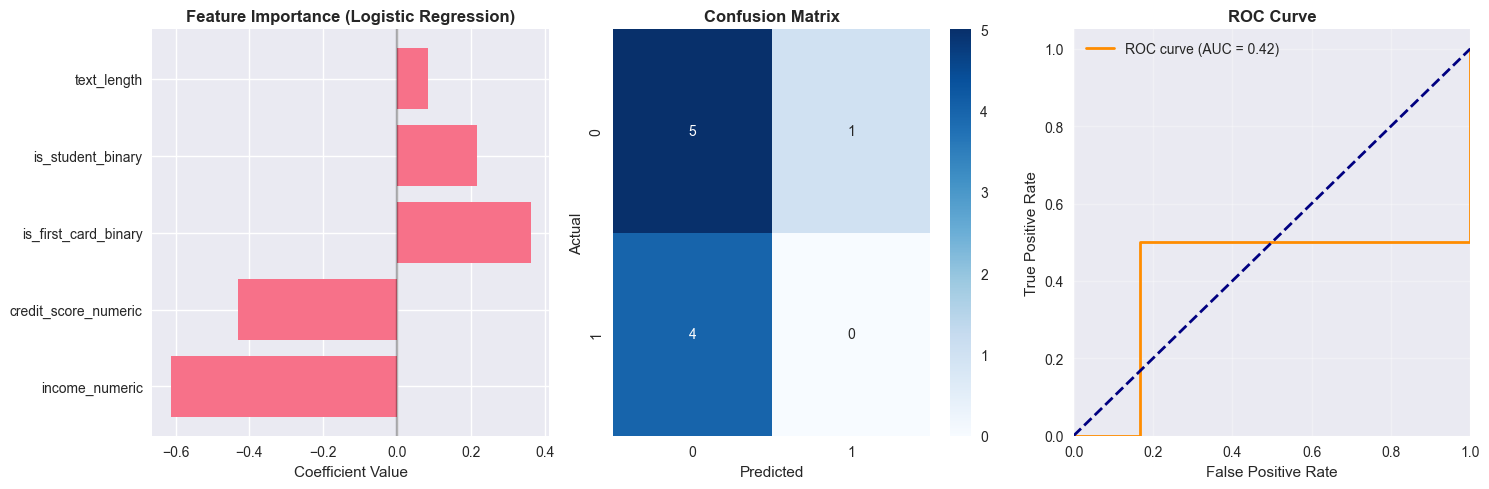


Sample Predictions:
   Actual  Predicted  Probability
0     0.0        0.0     0.226268
1     1.0        0.0     0.406176
2     0.0        0.0     0.397171
3     0.0        0.0     0.396846
4     0.0        0.0     0.334921
5     1.0        0.0     0.432407
6     1.0        0.0     0.092796
7     0.0        1.0     0.555009
8     1.0        0.0     0.223985
9     0.0        0.0     0.394849


In [41]:
# Prepare data for modeling
print("SIMPLE LOGISTIC REGRESSION (POC)")

# Create a clean dataset with only posts that have the features we need
modeling_df = df.copy()

# Convert income and credit score to numeric, replacing 'Not extracted' with NaN
modeling_df['income_numeric'] = pd.to_numeric(modeling_df['income_clean'], errors='coerce')
modeling_df['credit_score_numeric'] = pd.to_numeric(modeling_df['credit_score_clean'], errors='coerce')

# Create binary features
modeling_df['is_student_binary'] = (modeling_df['is_student'] == 'Yes').astype(int)
modeling_df['is_first_card_binary'] = (modeling_df['is_first_card'] == 'Yes').astype(int)

# Select features for modeling (REMOVED title_quality_score)
feature_columns = ['income_numeric', 'credit_score_numeric', 'is_student_binary', 'is_first_card_binary', 'text_length']
available_features = [col for col in feature_columns if col in modeling_df.columns]

print(f"Available features: {available_features}")

# Remove rows with NaN in target variable
modeling_df = modeling_df.dropna(subset=['target'])
print(f"After removing NaN targets: {len(modeling_df)} samples")

# Create feature matrix
X = modeling_df[available_features].fillna(0)  # Fill NaN with 0 for missing values
y = modeling_df['target'].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Sample sizes:")
for col in available_features:
    non_zero = (X[col] != 0).sum()
    print(f"  {col}: {non_zero}/{len(X)} non-zero values")

# Check if we have enough samples
if len(X) < 10:
    print("Not enough samples for modeling (need at least 10)")
else:
    # Simple train/test split (small dataset, so use more for training)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Results
    print(f"\nModel Performance:")
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print(f"\nFeature Importance:")
    for name, coef in zip(available_features, model.coef_[0]):
        print(f"{name}: {coef:.4f}")

    print(f"\nIntercept: {model.intercept_[0]:.4f}")

    # Create visualizations for model results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Feature importance bar chart
    feature_importance = pd.DataFrame({'Feature': available_features, 'Coefficient': model.coef_[0]})
    feature_importance = feature_importance.sort_values('Coefficient', key=abs, ascending=False)
    axes[0].barh(feature_importance['Feature'], feature_importance['Coefficient'])
    axes[0].set_title('Feature Importance (Logistic Regression)', fontweight='bold')
    axes[0].set_xlabel('Coefficient Value')
    axes[0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title('Confusion Matrix', fontweight='bold')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    # ROC curve
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.05])
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_title('ROC Curve', fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Show some predictions
    print(f"\nSample Predictions:")
    test_results = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_pred_proba
    })
    print(test_results.head(10))

### Cell 8: Key insights summary


In [40]:
print("KEY INSIGHTS SUMMARY")

print(f"Dataset Overview:")
print(f"- Total samples: {len(df)}")
print(f"- Approval rate: {df['target'].mean():.1%}")
print(f"- Denial rate: {1 - df['target'].mean():.1%}")

print(f"\nData Quality:")
print(f"- Income extracted: {df['income_clean'].notna().sum()}/{len(df)} ({df['income_clean'].notna().sum()/len(df)*100:.1f}%)")
print(f"- Credit score extracted: {df['credit_score_clean'].notna().sum()}/{len(df)} ({df['credit_score_clean'].notna().sum()/len(df)*100:.1f}%)")
print(f"- Approval amount extracted: {df['approval_amount_clean'].notna().sum()}/{len(df)} ({df['approval_amount_clean'].notna().sum()/len(df)*100:.1f}%)")

print(f"\nLLM Usage:")
if 'used_llm' in df.columns:
    llm_used = df['used_llm'].sum()
    print(f"- LLM validation used for {llm_used}/{len(df)} posts ({llm_used/len(df)*100:.1f}%)")

print(f"\nRecommendations for scaling up:")
print(f"1. Collect more data (aim for 500+ samples)")
print(f"2. Expand to other Chase cards")
print(f"3. Improve feature extraction")
print(f"4. Add more features (age, employment, etc.)")

KEY INSIGHTS SUMMARY
Dataset Overview:
- Total samples: 47
- Approval rate: 37.0%
- Denial rate: 63.0%

Data Quality:
- Income extracted: 47/47 (100.0%)
- Credit score extracted: 47/47 (100.0%)
- Approval amount extracted: 47/47 (100.0%)

LLM Usage:
- LLM validation used for 6/47 posts (12.8%)

Recommendations for scaling up:
1. Collect more data (aim for 500+ samples)
2. Expand to other Chase cards
3. Improve feature extraction
4. Add more features (age, employment, etc.)
